In [1]:
%config IPCompleter.greedy=True
#Press Shift + Tab to trigger autocomplete.

In [1]:
#**Import Libraries :**
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }
import numpy as np
from numpy import vstack
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCELoss
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import tensorflow as tf
import os
import PIL
from PIL import Image

import time 

import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

np.random.seed(0)
torch.manual_seed(0)

print("All libraries are imported successfully")

2024-11-02 10:59:45.931844: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 10:59:45.962580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 10:59:47.346782: I itex/core/wrapper/itex_cpu_wrapper.cc:42] Intel Extension for Tensorflow* AVX512 CPU backend is loaded.
2024-11-02 10:59:47.803878: I itex/core/wrapper/itex_gpu_wrapper.cc:35] Intel Extension for Tensorflow* GPU backend is loaded.
2024-11-02 10:59:47.843088: W itex/core/op

All libraries are imported successfully


In [2]:
# @title Defining  Paths and Parameters
class Path :
  def __init__(self, choice) :
    name = choice # choice = "132+800" | choice = "50+150" | choice = "206+200"

    self.training_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/" + name
    self.validation_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Validation_dataset/" + name
    self.test_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Test_dataset/" + name

    self.model_name = "VisionTransformer"
    self.model_path =  "/arf/home/edilek/ViT_Output/Models/"+ name + "/" + self.model_name + ".pth"

    self.w_h = 224
    self.n_patches = 14 # 14*14 patches, each 16px*16px => 14*16 = 224
    self.splitRatio = 0.20

print("Paths and Parameters are defined successfully")


Paths and Parameters are defined successfully


**Choice of Dataset and Parameters:**

In [3]:
#@title Choice of Dataset and Parameters { display-mode: "form" }
choice = "132+800" #@param ["132+800", "50+150", "206+200"]
paths = Path(choice)

w_h               = paths.w_h
n_patches         = paths.n_patches
splitRatio        = paths.splitRatio
model_name        = paths.model_name
model_path        = paths.model_path

array([[ 14,  17,  17, ...,  16,  18,  17],
       [ 19,  14,  16, ...,  19,  12,  14],
       [ 15, 169,  55, ...,  51,  19,  17],
       ...,
       [ 88,  88,  85, ...,  76,  75,  73],
       [ 88,  86,  84, ...,  76,  75,  73],
       [ 87,  85,  85, ...,  76,  76,  75]], dtype=uint8)

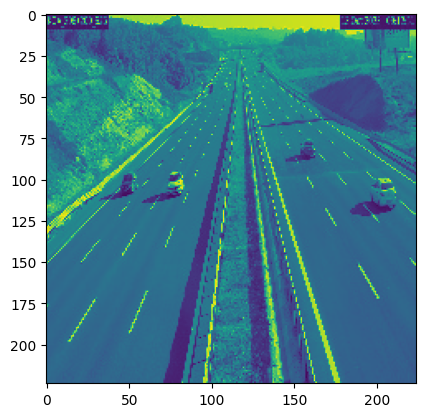

In [4]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg")
plt.imshow(img)

import cv2 
# read image
img = cv2.imread('/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg', cv2.IMREAD_UNCHANGED)
img 


In [5]:
# https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

def patchify(images, n_patches):
    n, c, h, w = images.shape

    #print("patchify n:", n, "c:", c, "h:", h, "w:", w)
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    
    #print("patches cnt:", len(patches))
    
    return patches

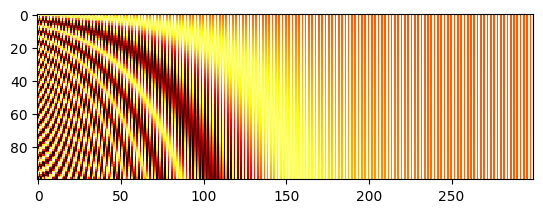

In [6]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [7]:
class MyMHSA(nn.Module):
    def __init__(self, d, n_heads=12):
        super(MyMHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [8]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [9]:
model = MyViTBlock(hidden_d=8, n_heads=2)

x = torch.randn(7, 50, 8)  # Dummy sequences
print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [10]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=n_patches, n_blocks=12, hidden_d=768, n_heads=12, out_d=2):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLP
        self.mlp = nn.Sequential(
            nn.LayerNorm(normalized_shape = self.hidden_d),
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        #print("forward n:", n, "c:", c, "h:", h, "w:", w)
        
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [11]:
BATCH_SIZE = 32
x = torch.randn(BATCH_SIZE, 3, 224, 224) # Dummy images
model = MyViT(
    chw=(3, 224, 224),
    n_patches=14
  )
print(model(x).shape) # torch.Size([BATCH_SIZE, 196, 768])

torch.Size([32, 2])


In [12]:
print("MyViT Summary:") 
summary(model=model, 
        input_size=(BATCH_SIZE, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

MyViT Summary:


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MyViT (MyViT)                                 [32, 3, 224, 224]    [32, 2]              768                  True
├─Linear (linear_mapper)                      [32, 196, 768]       [32, 196, 768]       590,592              True
├─ModuleList (blocks)                         --                   --                   --                   True
│    └─MyViTBlock (0)                         [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─LayerNorm (norm1)                 [32, 197, 768]       [32, 197, 768]       1,536                True
│    │    └─MyMHSA (mhsa)                     [32, 197, 768]       [32, 197, 768]       149,760              True
│    │    └─LayerNorm (norm2)                 [32, 197, 768]       [32, 197, 768]       1,536                True
│    │    └─Sequential (mlp)                  [32, 197, 768]       [32, 197, 768]  

In [13]:
 # Current model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ViT = MyViT(chw=(3, w_h, w_h), n_patches=n_patches, n_blocks=2, hidden_d=8, n_heads=2, out_d=2).to(device)

x = torch.randn(n_patches, 3, w_h, w_h) # Dummy images
print(model_ViT(x).shape) # torch.Size([56, 2])

torch.Size([14, 2])


In [14]:
#@title Create Output Folders

def create_output_folders():
   
  if not os.path.exists("/arf/home/edilek/ViT_Output/Images/" + choice + "/Confusion_Matrix/"): 
      os.makedirs("/arf/home/edilek/ViT_Output/Images/" + choice + "/Confusion_Matrix/")
      
  if not os.path.exists("/arf/home/edilek/ViT_Output/Images/" + choice + "/ROC/"):
      os.makedirs("/arf/home/edilek/ViT_Output/Images/" + choice + "/ROC/")
      
  if not os.path.exists("/arf/home/edilek/ViT_Output/Images/" + choice + "/Accuracy/"):
      os.makedirs("/arf/home/edilek/ViT_Output/Images/" + choice + "/Accuracy/")
      
  if not os.path.exists("/arf/home/edilek/ViT_Output/Images/" + choice + "/Loss/"): 
      os.makedirs("/arf/home/edilek/ViT_Output/Images/" + choice + "/Loss/")

  if not os.path.exists("/arf/home/edilek/ViT_Output/Models/" + choice +"/"): 
      os.makedirs("/arf/home/edilek/ViT_Output/Models/" + choice + "/")

create_output_folders()

In [15]:
def main():
    # Loading data
    transform = transforms.Compose([  transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                                    ])
    
    train_set      = datasets.ImageFolder(paths.training_dataset, transform=transform)
    validation_set = datasets.ImageFolder(paths.validation_dataset, transform=transform)
    test_set       = datasets.ImageFolder(paths.test_dataset, transform=transform)

    print("len train_set:", len(train_set))
    print("len validation_set:", len(validation_set))
    print("len test_set:", len(test_set))
    
    len_train_set      = len(train_set)
    len_validation_set = len(validation_set)
    len_test_set       = len(test_set)
    
    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    valid_loader = DataLoader(validation_set, shuffle=True, batch_size=128)
    test_loader  = DataLoader(test_set, shuffle=False, batch_size=128)
    
    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    #print("n_patches:", n_patches)
    model = MyViT(chw=(3, w_h, w_h), n_patches=n_patches, n_blocks=12, hidden_d=768, n_heads=12, out_d=2).to(device)
    
    N_EPOCHS = 3
    LR = 0.001

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss() 
    train_acc_values, val_acc_values, train_loss_values, val_loss_values = list(), list(), list(), list()
    
    train_time = 0
    valid_time = 0
    test_time = 0
    
    for epoch in trange(N_EPOCHS, desc="Training"):
        ###########################################################################
        print("Training epoch:", epoch+1)
        t0 = time.time()
        
        model.train(True)

        train_accuracy = 0.0    
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            #print("batch.shape:", batch[0].shape)
            x, y = batch            
            x, y = x.to(device), y.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            y_hat = model(x)

            #print("x.shape:", x.shape, " y.shape:", y.shape, "y_hat shape :", y_hat.shape)

            # Compute the loss and its gradients
            loss = criterion(y_hat, y)  
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            train_loss += loss.detach().cpu().item() / len(train_loader)

            acc = (y_hat.argmax(dim=1) == y).float().mean()
            train_accuracy += acc / len(train_loader)

        t1 = round(time.time() - t0)
        train_time = train_time + t1
        ###########################################################################
        
        print("Validating epoch:", epoch+1)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        
        t0 = time.time()
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_accuracy = 0.0
            val_loss = 0.0
            
            for batch in tqdm(valid_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                
                loss = criterion(y_hat, y)            
                val_loss += loss.detach().cpu().item() / len(valid_loader)

                acc = (y_hat.argmax(dim=1) == y).float().mean()
                val_accuracy += acc / len(valid_loader)
        
        t1 = round(time.time() - t0)
        valid_time = valid_time + t1
        ###########################################################################
        # Store train/validation acc/loss history 
        
        train_acc_values.append(torch.round(train_accuracy, decimals=2))
        val_acc_values.append(torch.round(val_accuracy, decimals=2))
        
        train_loss_values.append(torch.round(torch.as_tensor(train_loss), decimals=2))
        val_loss_values.append(torch.round(torch.as_tensor(val_loss), decimals=2))
        
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")
        print(f"Epoch : {epoch+1} - loss : {train_loss:.4f} - acc: {train_accuracy:.4f} - val_loss : {val_loss:.4f} - val_acc: {val_accuracy:.4f}\n")
        ###########################################################################

    # Save the model's state
    torch.save(model.state_dict(), model_path)

    #############################################################################
    # Draw Training/Validation Accuracy Graph
    acc     = train_acc_values
    val_acc = val_acc_values
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_acc_values).cpu().numpy(), label='Training Accuracy')  
    plt.plot(torch.stack(val_acc_values).cpu().numpy(), label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_Output/Images/" + choice + "/Accuracy/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

    # Draw Training/Validation Loss Graph
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_loss_values).cpu().numpy(), label='Training Loss')
    plt.plot(torch.stack(val_loss_values).cpu().numpy(), label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_Output/Images/" + choice + "/Loss/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    ###############################################################################

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        predictions, actuals = list(), list()
        
        for batch in tqdm(test_loader, desc="Testing"):
            t0 = time.time()
            
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            
            t1 = round(time.time() - t0)
            test_time = test_time + t1
            
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            
            # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item() 
            total += len(x)

            #print("x.shape:", x.shape, "y.shape:", y.shape, " y_hat.shape:", y_hat.shape)
            #print("y[0]:", y[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])
            
            ############ Calculate accuracy in a different way ###########
            
            #print("yhat shape1:", y_hat.shape)
            # retrieve numpy array
            y_hat = y_hat.detach().cpu().numpy()
            #print("yhat shape2:", y_hat.shape)
            # round to class values
            y_hat = y_hat.round() 
            
            actual = y.detach().cpu().numpy()
            actual = actual.reshape((len(actual), 1))                       
            
            # store y_hat and actual values
            p = np.argmax(y_hat, axis=1).reshape((len(y_hat), 1)) # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            #print("actual[0]:", actual[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])            
            predictions.append(p) 
            actuals.append(actual)    
            #print("actual.shape:", actual.shape, " y_hat.shape:", y_hat.shape, " prediction.shape:", p.shape)
            #print("actual:", actual," prediction:", p)
            ###########################################################
        
        print(f"Test loss: {test_loss:.4f} Test accuracy: {correct / total * 100:.2f}%")
        #print(f"Test accuracy: {correct / total * 100:.2f}%")

        ############ Calculate accuracy in a different way ###########
        predictions, actuals = vstack(predictions), vstack(actuals)
        acc = metrics.accuracy_score(actuals, predictions)         
        print(f"Test accuracy 2: {acc * 100:.2f}%")

        print("actuals.shape:", actuals.shape, " predictions.shape:", predictions.shape)
        actuals = tf.squeeze(actuals)
        predictions = tf.squeeze(predictions)
        ##############################################################
        print("\n")
        print(f"Training time: {train_time:.4f}s Validation time: {valid_time:.4f}s Test time: {test_time:.4f}s")
        print(f"Training time of a frame: {(train_time/len_train_set):.4f}s")
        print(f"Validation time of a frame: {(valid_time/len_validation_set):.4f}s")
        print(f"Prediction time of a frame: {(test_time/len_test_set):.4f}s")
        if test_time > 0 :
            fps = round(len_test_set/test_time)
            print(f"fps: {fps}")
        ##############################################################

        # Calculation of Metrics
        # Accuracy = metrics.accuracy_score(actual, predicted)
        # Precision = metrics.precision_score(actual, predicted)
        # Sensitivity_recall = metrics.recall_score(actual, predicted)
        # Specificity = metrics.recall_score(actual, predicted, pos_label=0)
        # F1_score = metrics.f1_score(actual, predicted)

        #############################################################################
        # Create Confusion Matrix

        TP, FN, FP, TN = confusion_matrix(actuals, predictions).ravel()

        print('\n')
        print('True Positive(TP)  = ', TP)
        print('False Positive(FP) = ', FP)
        print('True Negative(TN)  = ', TN)
        print('False Negative(FN) = ', FN)
        accuracy =  (TP + TN) / (TP + FP + TN + FN)
        precision = TP/(TP + FP)
        recall = TP / (TP + FN)
        F1_score = (2 * precision * recall)/(precision + recall)
        print('Accuracy = {:0.4f}'.format(accuracy), ' Precision = {:0.4f}'.format(precision), ' Recall = {:0.4f}'.format(recall), ' F1 Score = {:0.4f}'.format(F1_score))
        print('\n')  

        cm = tf.math.confusion_matrix(actuals, predictions)
        cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
        plt.figure(figsize=(10, 7))
        sbn.set(font_scale=1.6)
        sbn.heatmap(cm,cmap="YlGnBu",cbar=False, xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'], annot=True, fmt='.4f')
        plt.title(model_name)
        plt.xlabel('Predicted',labelpad=10)
        plt.ylabel('Actual',labelpad=10)
        plt.savefig(("/arf/home/edilek/ViT_Output/Images/" + choice + "/Confusion_Matrix/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################

        #############################################################################
        # Create Classification Report
        from sklearn.metrics import classification_report
        target_names = ['Anomaly','Normal']
        print(classification_report(actuals, predictions, target_names=target_names))
        #############################################################################

        #############################################################################
        # Draw ROC Curve
        fpr,tpr,thresholds = metrics.roc_curve(actuals, predictions)
        auc = metrics.roc_auc_score(actuals, predictions)
        print("AUC = {:0.4f}".format(auc))
        plt.figure(figsize=(10, 7))
        plt.title("Camera No:"+ choice +" ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr,tpr, label='ROC curve of '+ model_name.upper() +' (AUC = '+  "{:.4f}".format(auc)+')')
        plt.legend(fontsize="xx-small", bbox_to_anchor =(1.0, 0.07), loc='lower right')
        plt.axhline(0, color="black", alpha=0.3)
        plt.axvline(0, color="black", alpha=0.3)
        plt.savefig(("/arf/home/edilek/ViT_Output/Images/" + choice + "/ROC/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################    

In [ ]:
main()

len train_set: 12733
len validation_set: 2547
len test_set: 638


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training epoch: 1



Epoch 1 in training:   0%|          | 0/100 [00:00<?, ?it/s]